### 엣지 검출과 미분

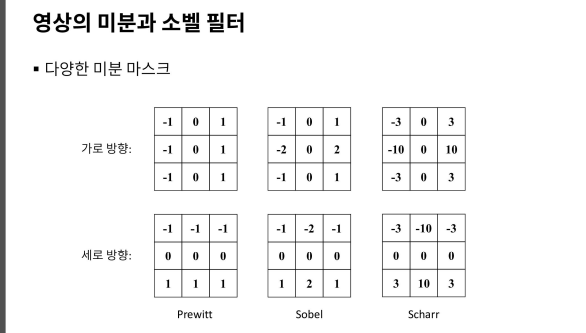

- 이 중 소벨(sobel) 필터를 많이 사용함.

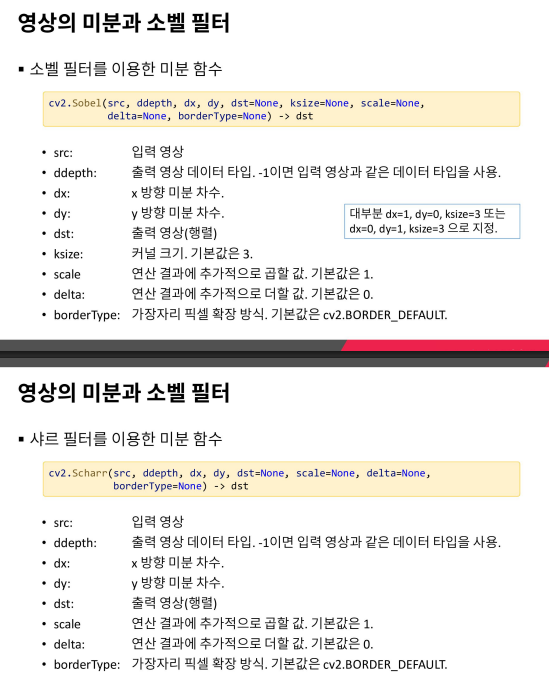

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

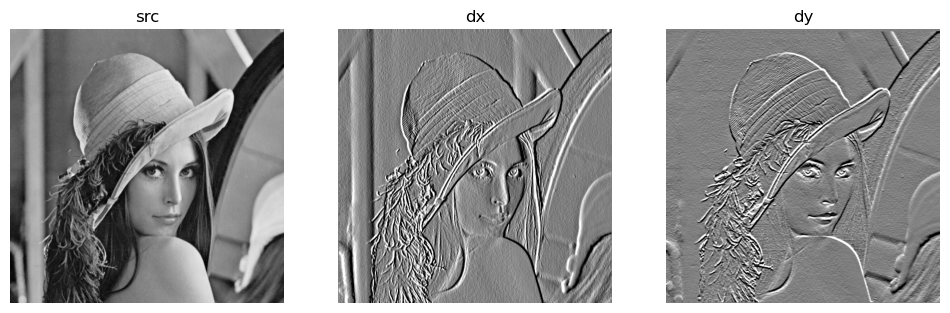

In [18]:
#  소벨 필터를 이용한 미분 예제

src = cv2.imread('images/lenna.bmp', cv2.IMREAD_GRAYSCALE)

dx = cv2.Sobel(src, -1, 1 ,0, delta=128)
dy = cv2.Sobel(src, -1, 0, 1, delta=128) # delta = 결과값에 더하는 상수(밝기 시프트용)

plt.figure(figsize=(12,4))
plt.subplot(131), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(132), plt.title('dx'), plt.axis('off'), plt.imshow(dx, 'gray')
plt.subplot(133), plt.title('dy'), plt.axis('off'), plt.imshow(dy, 'gray')
plt.show()

### 그래디언트(gradient) == 미분과 다를 바가 없다고 함.

### 캐니 엣지 검출

- 가우시안 필터링(잡음 제거 목적) -> 그래디언트 계산(크기 & 방향) -> 비최대 억제 -> 이중 임계값을 이용한 히스테리시스 엣지 트래킹 


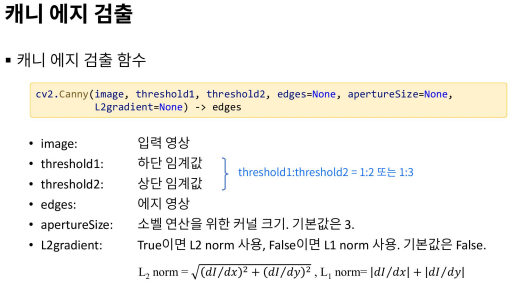

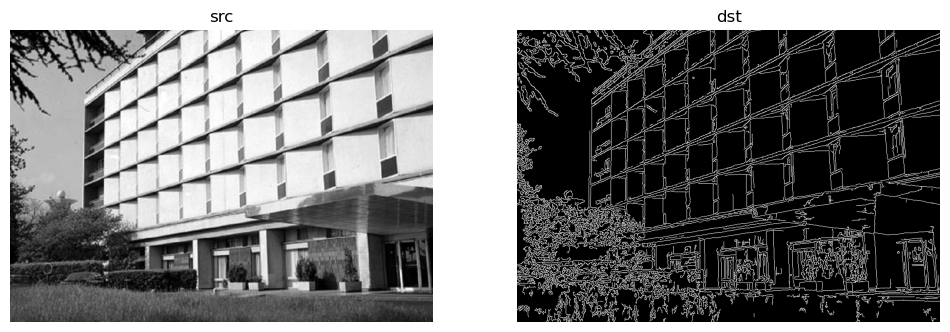

In [25]:
# 케니 엣지 검출 예제

src = cv2.imread('images/building.jpg', cv2.IMREAD_GRAYSCALE)

dst = cv2.Canny(src, 50, 150)

plt.figure(figsize=(12,4))
plt.subplot(121), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(122), plt.title('dst'), plt.axis('off'), plt.imshow(dst, 'gray')
plt.show()

# src2 = cv2.imread('images/lenna.bmp', cv2.IMREAD_GRAYSCALE)
# dst2 = cv2.Canny(src2, 50, 300)
# plt.figure(figsize=(12,4))
# plt.subplot(121), plt.title('src2'), plt.axis('off'), plt.imshow(src2, 'gray')
# plt.subplot(122), plt.title('dst2'), plt.axis('off'), plt.imshow(dst2, 'gray')
# plt.show()

### 허프 변환 : 직선 검출
- 2차원 영상 좌표에서의 직선의 방정식을 파라미터 공간으로 변환하여 직선을 찾는 알고리즘

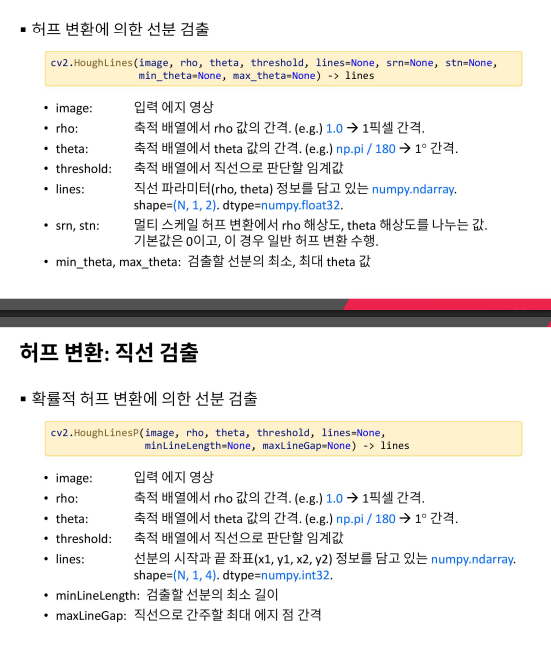

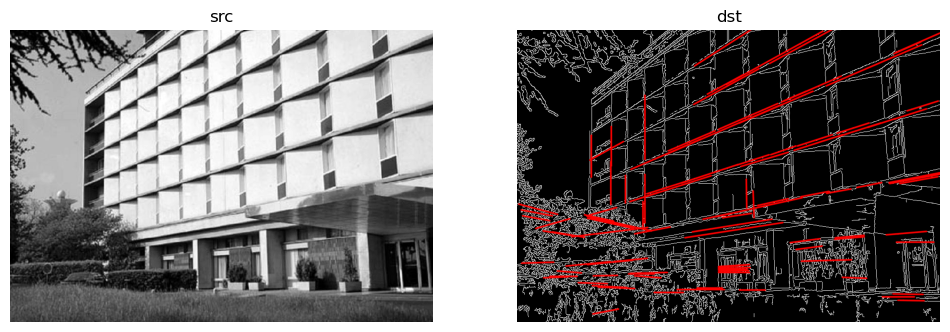

In [ ]:
# 확률적 허프 변환 직선 검출 예제

src = cv2.imread('images/building.jpg', cv2.IMREAD_GRAYSCALE)

edges = cv2.Canny(src, 50, 150)

lines = cv2.HoughLinesP(edges, 1.0, np.pi / 100., 160,
                        minLineLength=50, maxLineGap=5)\

dst = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

if lines is not None:
    for i in range(lines.shape[0]):
        pt1 = (lines[i][0][0], lines[i][0][1]) # 시작점 좌표
        pt2 = (lines[i][0][2], lines[i][0][3]) # 끝점 좌표
        cv2.line(dst, pt1, pt2, (0, 0, 255), 2, cv2.LINE_AA) # 라인 선 빨간색
        
plt.figure(figsize=(12,4))
plt.subplot(121), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(122), plt.title('dst'), plt.axis('off'), plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show() 

### 허프 변환 : 원 검출

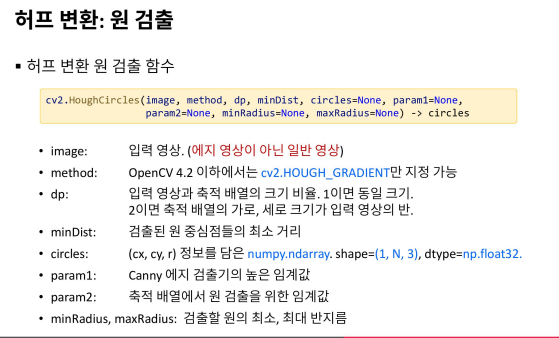

In [ ]:
# 허프 변환 원 검출 예제

src = cv2.imread('images/dial.jpg')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
blr = cv2.GaussianBlur(gray, (0,0), 0.5) # cv2.Hough_GRADIENT 방법 사용 시 블러링 권장

def on_trackbar(pos):
    rmin = cv2.getTrackbarPos('minRadius', 'img')
    rmax = cv2.getTrackbarPos('maxRadius', 'img')
    th = max(1, cv2.getTrackbarPos('threshold', 'img')) # th를 최소 1로 보정, 안하면 실행은 되는데 에러가 나옴.
    # th = cv2.getTrackbarPos('threshold', 'img') # error : (-211:One of the arguments' values is out of range
    
    circles = cv2.HoughCircles(blr, cv2.HOUGH_GRADIENT, 1, 50,
                               param1=120, param2=th, minRadius=rmin, maxRadius=rmax)
    
    dst = src.copy()
    if circles is not None:
        for i in range(circles.shape[1]):
            cx, cy, radius = np.uint16(circles[0][i])
            cv2.circle(dst, (cx, cy), radius, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow('img', dst)


# 트랙바 생성
cv2.imshow('img', src)
cv2.createTrackbar('minRadius', 'img', 0, 100, on_trackbar)
cv2.createTrackbar('maxRadius', 'img', 0, 150, on_trackbar)
cv2.createTrackbar('threshold', 'img', 0, 100, on_trackbar)
cv2.setTrackbarPos('minRadius', 'img', 10)
cv2.setTrackbarPos('maxRadius', 'img', 80)
cv2.setTrackbarPos('threshold', 'img', 40)
cv2.waitKey()

cv2.destroyAllWindows()


### [실전 코딩] 동전 카운터

In [34]:
import sys

# 입력 이미지 불러오기
src = cv2.imread('images/coins1.jpg')

if src is None:
    print('Image open failed!')
    sys.exit()

gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
blr = cv2.GaussianBlur(gray, (0, 0), 1)

# 허프 변환 원 검출
circles = cv2.HoughCircles(blr, cv2.HOUGH_GRADIENT, 1, 50,
                           param1=150, param2=40, minRadius=20, maxRadius=80)

# 원 검출 결과 및 동전 금액 출력
sum_of_money = 0
dst = src.copy()
if circles is not None:
    for i in range(circles.shape[1]):
        cx, cy, radius = np.uint16(circles[0][i])
        cv2.circle(dst, (cx, cy), radius, (0, 0, 255), 2, cv2.LINE_AA)

        # 동전 영역 부분 영상 추출
        x1 = int(cx - radius)
        y1 = int(cy - radius)
        x2 = int(cx + radius)
        y2 = int(cy + radius)
        radius = int(radius)
        
        crop = dst[y1:y2, x1:x2, :]
        ch, cw = crop.shape[:2]

        # 동전 영역에 대한 ROI 마스크 영상 생성
        mask = np.zeros((ch, cw), np.uint8)
        cv2.circle(mask, (cw//2, ch//2), radius, 255, -1)

        # 동전 영역 Hue 색 성분을 +40 시프트하고, Hue 평균을 계산
        hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
        hue, _, _ = cv2.split(hsv)
        hue_shift = (hue + 40) % 180
        mean_of_hue = cv2.mean(hue_shift, mask)[0]

        # Hue 평균이 90보다 작으면 10원, 90보다 크면 100원으로 간주
        won = 100
        if mean_of_hue < 90:
            won = 10

        sum_of_money += won

        cv2.putText(crop, str(won), (20, 50), cv2.FONT_HERSHEY_SIMPLEX,
                    0.75, (255, 0, 0), 2, cv2.LINE_AA)

cv2.putText(dst, str(sum_of_money) + ' won', (40, 80),
            cv2.FONT_HERSHEY_DUPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.waitKey()

cv2.destroyAllWindows()


### 동전 카운터 근데 트랙바를 곁들인

In [44]:



# # 입력 이미지 불러오기
# src = cv2.imread('images/coins1.jpg')

# if src is None:
#     print('Image open failed!')
#     sys.exit()


# def on_trackbar(pos):
#     rmin = cv2.getTrackbarPos('minRadius', 'img')
#     rmax = cv2.getTrackbarPos('maxRadius', 'img')
#     th = max(1, cv2.getTrackbarPos('threshold', 'img')) # th를 최소 1로 보정, 안하면 실행은 되는데 에러가 나옴.
#     # th = cv2.getTrackbarPos('threshold', 'img') # error : (-211:One of the arguments' values is out of range
    
#     circles = cv2.HoughCircles(blr, cv2.HOUGH_GRADIENT, 1, 50,
#                                param1=120, param2=th, minRadius=rmin, maxRadius=rmax)
    
#     sum_of_money = 0

    
#     dst = src.copy()
#     if circles is not None:
#         for i in range(circles.shape[1]):
#             cx, cy, radius = np.uint16(circles[0][i])
#             cv2.circle(dst, (cx, cy), radius, (0, 0, 255), 2, cv2.LINE_AA)
            
#             # 동전 영역 부분 영상 추출
#             x1 = int(cx - radius)
#             y1 = int(cy - radius)
#             x2 = int(cx + radius)
#             y2 = int(cy + radius)
#             radius = int(radius)
            
#             crop = dst[y1:y2, x1:x2, :]
#             ch, cw = crop.shape[:2]

#             mask = np.zeros((ch, cw), np.uint8)
#             cv2.circle(mask, (cw//2, ch//2), radius, 255, -1)

#             hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
#             hue, _, _ = cv2.split(hsv)
#             hue_shift = (hue + 40) % 180
#             mean_of_hue = cv2.mean(hue_shift, mask)[0]

#             won = 100
#             if mean_of_hue < 90:
#                 won = 10

#             text = str(won)
#             (text_w, text_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
#             cv2.putText(dst, text, (cx - text_w // 2, cy + text_h // 2),
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)

#             sum_of_money += won

            
            
#         cv2.putText(dst, str(sum_of_money) + ' won', (40, 80), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
#     cv2.imshow('img', dst)


# gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
# blr = cv2.GaussianBlur(gray, (0, 0), 1)

# # 허프 변환 원 검출
# circles = cv2.HoughCircles(blr, cv2.HOUGH_GRADIENT, 1, 50,
#                            param1=150, param2=40, minRadius=20, maxRadius=80)

# # 원 검출 결과 및 동전 금액 출력
# # sum_of_money = 0
# dst = src.copy()
# if circles is not None:
#     for i in range(circles.shape[1]):
#         cx, cy, radius = np.uint16(circles[0][i])
#         cv2.circle(dst, (cx, cy), radius, (0, 0, 255), 2, cv2.LINE_AA)

#         # 동전 영역 부분 영상 추출
#         x1 = int(cx - radius)
#         y1 = int(cy - radius)
#         x2 = int(cx + radius)
#         y2 = int(cy + radius)
#         radius = int(radius)
        
#         crop = dst[y1:y2, x1:x2, :]
#         ch, cw = crop.shape[:2]

#         # 동전 영역에 대한 ROI 마스크 영상 생성
#         mask = np.zeros((ch, cw), np.uint8)
#         cv2.circle(mask, (cw//2, ch//2), radius, 255, -1)

#         # 동전 영역 Hue 색 성분을 +40 시프트하고, Hue 평균을 계산
#         hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
#         hue, _, _ = cv2.split(hsv)
#         hue_shift = (hue + 40) % 180
#         mean_of_hue = cv2.mean(hue_shift, mask)[0]

#         # Hue 평균이 90보다 작으면 10원, 90보다 크면 100원으로 간주
#         won = 100
#         if mean_of_hue < 90:
#             won = 10

#         sum_of_money += won

#         cv2.putText(crop, str(won), (cx - 20, cy + 10), cv2.FONT_HERSHEY_SIMPLEX,
#                     0.75, (255, 0, 0), 2, cv2.LINE_AA)

# # cv2.putText(dst, str(sum_of_money) + ' won', (40, 80),
# #             cv2.FONT_HERSHEY_DUPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)

# # 트랙바 생성
# cv2.imshow('img', src)
# cv2.createTrackbar('minRadius', 'img', 0, 100, on_trackbar)
# cv2.createTrackbar('maxRadius', 'img', 0, 150, on_trackbar)
# cv2.createTrackbar('threshold', 'img', 0, 100, on_trackbar)
# cv2.setTrackbarPos('minRadius', 'img', 10)
# cv2.setTrackbarPos('maxRadius', 'img', 80)
# cv2.setTrackbarPos('threshold', 'img', 40)
# cv2.waitKey()

# cv2.destroyAllWindows()



C:\Users\main\AppData\Local\Temp\ipykernel_16596\1523740174.py:28: RuntimeWarning: overflow encountered in scalar subtract
  x1 = int(cx - radius)


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [45]:
# 위에거 코드 정리 한거

import cv2
import numpy as np
import sys

# 이미지 불러오기
src = cv2.imread('images/coins1.jpg')
if src is None:
    print('Image open failed!')
    sys.exit()

gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
blr = cv2.GaussianBlur(gray, (0, 0), 1)

def detect_coins(threshold, rmin, rmax):
    """동전 검출 및 인식"""
    dst = src.copy()
    sum_of_money = 0

    circles = cv2.HoughCircles(blr, cv2.HOUGH_GRADIENT, 1, 50,
                               param1=120, param2=threshold,
                               minRadius=rmin, maxRadius=rmax)

    if circles is not None:
        for i in range(circles.shape[1]):
            cx, cy, radius = np.uint16(circles[0][i])
            cv2.circle(dst, (cx, cy), radius, (0, 0, 255), 2, cv2.LINE_AA)

            x1, y1 = int(cx - radius), int(cy - radius)
            x2, y2 = int(cx + radius), int(cy + radius)

            crop = dst[y1:y2, x1:x2]
            if crop.size == 0:
                continue  # 잘린 경우 방지

            ch, cw = crop.shape[:2]
            mask = np.zeros((ch, cw), np.uint8)
            cv2.circle(mask, (cw // 2, ch // 2), int(radius), 255, -1)

            hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            hue, _, _ = cv2.split(hsv)
            hue_shift = (hue + 40) % 180
            mean_hue = cv2.mean(hue_shift, mask)[0]

            won = 100 if mean_hue >= 90 else 10
            sum_of_money += won

            text = str(won)
            (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
            cv2.putText(dst, text, (cx - tw // 2, cy + th // 2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.putText(dst, f'{sum_of_money} won', (40, 80),
                cv2.FONT_HERSHEY_DUPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
    return dst

def on_trackbar(pos):
    """트랙바 콜백"""
    rmin = cv2.getTrackbarPos('minRadius', 'img')
    rmax = cv2.getTrackbarPos('maxRadius', 'img')
    th = max(1, cv2.getTrackbarPos('threshold', 'img'))  # 최소값 보정

    result = detect_coins(threshold=th, rmin=rmin, rmax=rmax)
    cv2.imshow('img', result)

# 트랙바 UI 세팅
cv2.namedWindow('img')
cv2.createTrackbar('minRadius', 'img', 10, 100, on_trackbar)
cv2.createTrackbar('maxRadius', 'img', 80, 150, on_trackbar)
cv2.createTrackbar('threshold', 'img', 40, 100, on_trackbar)

# 첫 화면 출력
on_trackbar(0)

cv2.waitKey()
cv2.destroyAllWindows()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:868: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:868: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


C:\Users\main\AppData\Local\Temp\ipykernel_16596\838752550.py:30: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = int(cx - radius), int(cy - radius)


### 영상의 이진화
- 영상의 픽셀 값을 0 또는 255(1)로 만드는 연산

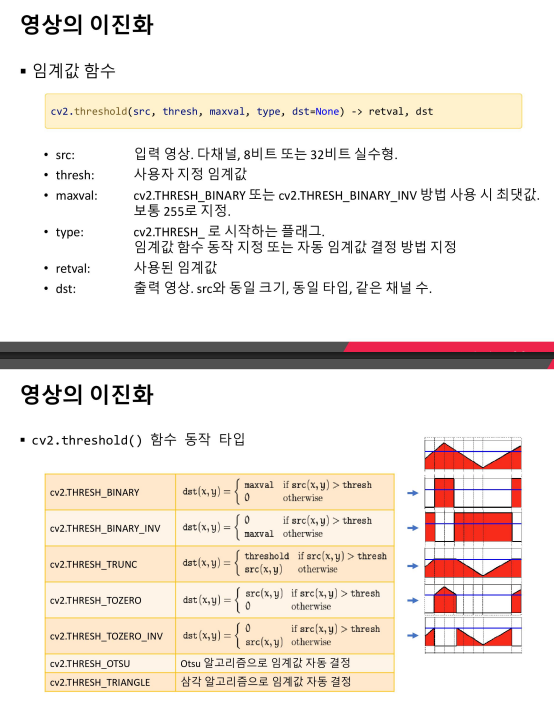

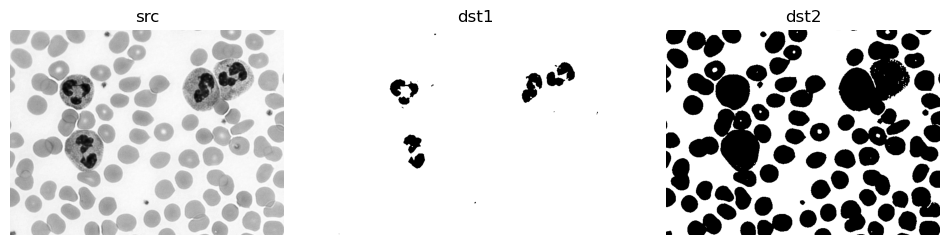

In [53]:
# 영상의 이진화 예제

src = cv2.imread('images/cells.png', cv2.IMREAD_GRAYSCALE)

_, dst1 = cv2.threshold(src, 100, 255, cv2.THRESH_BINARY)
_, dst2 = cv2.threshold(src, 210, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,4))
plt.subplot(131), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(132), plt.title('dst1'), plt.axis('off'), plt.imshow(dst1, 'gray')
plt.subplot(133), plt.title('dst2'), plt.axis('off'), plt.imshow(dst2, 'gray')
plt.show() 

### 자동 이진화

- Otsu 이진화 방법
- - 입력 영상이 배경과 객체 두 개로 구성되어 있다고 가정 -> Bimodal histogram
- - 임의의 임계값 T에 의해 나눠지는 두 픽셀 분포 그룹의 분산이 최고사 되는 T를 선택
- - 일종의 최적화 알고리즘

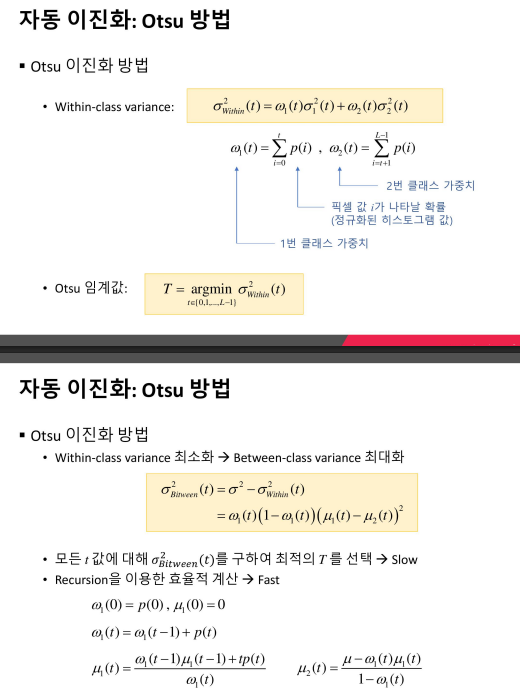

otsu's threshold : 131.0


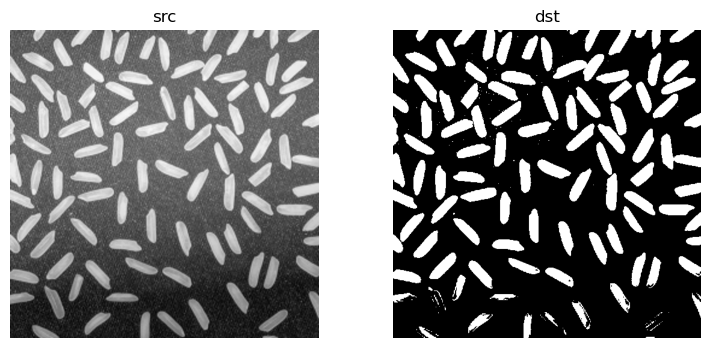

In [60]:
# Otsu 방법을 이용한 자동 이진화

src = cv2.imread('images/rice.png', cv2.IMREAD_GRAYSCALE)

th, dst = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("otsu's threshold :", th) # 131.0

plt.figure(figsize=(12,4))
plt.subplot(121), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(122), plt.title('dst'), plt.axis('off'), plt.imshow(dst, 'gray')
plt.subplots_adjust(wspace = -0.3)
plt.show() 

### 지역 이진화
- 균일하지 않은 조명 환경에서 촬영된 영상의 이진화

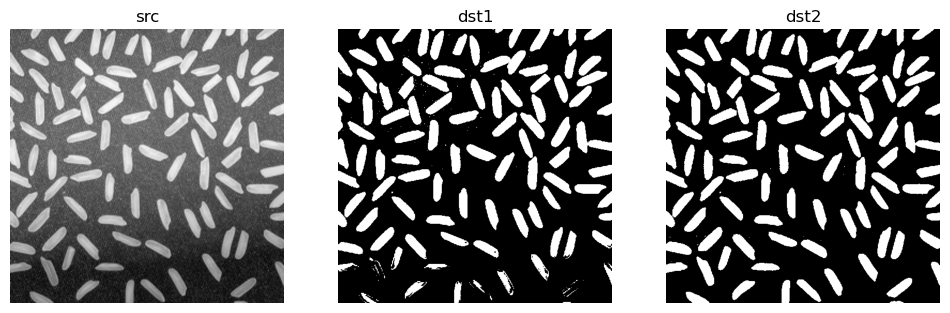

In [61]:
# 지역 이진화 예제

src = cv2.imread('images/rice.png', cv2.IMREAD_GRAYSCALE)

# 전역 이진화 by Otsu's method
_, dst1 = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 지역 이진화 by Otsu's method
dst2 = np.zeros(src.shape, np.uint8)

bw = src.shape[1] // 4
bh = src.shape[0] // 4

for y in range(4):
    for x in range(4):
        src_ = src[y*bh : (y+1)*bh, x*bw:(x+1)*bw]
        dst_ = dst2[y*bh : (y+1)*bh, x*bw:(x+1)*bw]
        cv2.threshold(src_, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU, dst_)
        
plt.figure(figsize=(12,4))
plt.subplot(131), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(132), plt.title('dst1'), plt.axis('off'), plt.imshow(dst1, 'gray')
plt.subplot(133), plt.title('dst2'), plt.axis('off'), plt.imshow(dst2, 'gray')
plt.show() 

### 지역 이진화
- OpenCV 적응형 이진화

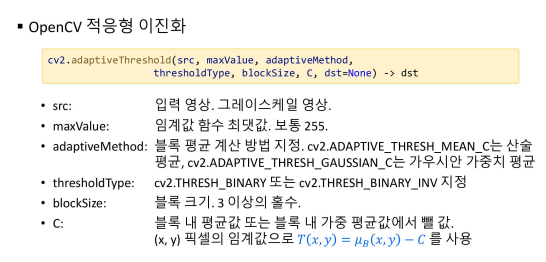

In [62]:
# OpenCV 적응형 이진화 예제

src = cv2.imread('images/sudoku.jpg', cv2.IMREAD_GRAYSCALE)

def on_trackbar(pos) :
    bsize = pos
    if bsize % 2 == 0:
        bsize = bsize - 1
    if bsize < 3 :
        bsize = 3
        
    dst = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY, bsize, 5)
    
    cv2.imshow('dst', dst)
    
cv2.imshow('src', src)
cv2.namedWindow('dst')
cv2.createTrackbar('Block Size', 'dst', 0, 200, on_trackbar)
cv2.setTrackbarPos('Block Size', 'dst', 11)
cv2.waitKey()
cv2.destroyAllWindows()

### 모폴로지
- 영상을 형태학적인 측면에서 다루는 기법
- 다양한 영상 처리 시스템에서 전처리 또는 후처리 형태로 널리 사용
- 수학적 모폴로지

#### 구조 요소
- 모폴로지 연산의 결과를 결정하는 커널, 마스크, 윈도우

<br>
<hr>
<br>

### 모폴로지(1) : 침식과 팽창
<br>

#### 이진 영상의 침식(erosion) 연산
- 구조 요소가 객체 영역 내부에 완전히 포함될 경우 고정점 픽셀을 255로 설정
- 침식 연산은 객체 외곽을 깍아내는 연산 -> 객체 크기는 감소 & 배경은 확대
<br>

- 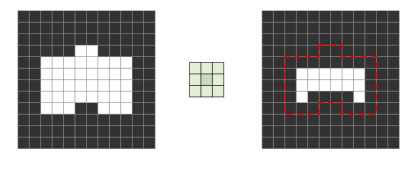

<br>

#### 이진 영상의 팽창(dilation) 연산
- 구조 요소와 객체 영역이 한 픽셀이라도 만날 경우 고정점 픽셀을 255로 설정
- 팽창 연산은 객체 외곽을 확대시키는 연산 -> 객체크기는 확대 & 배경은 감소
<br>

- 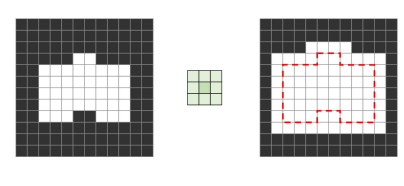

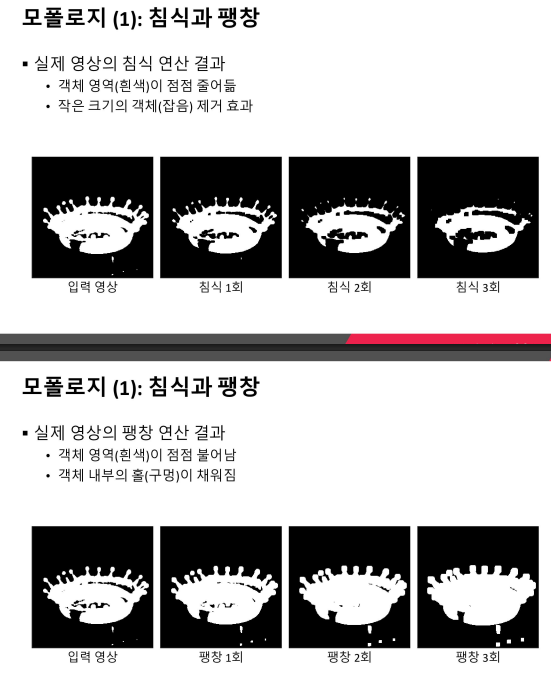

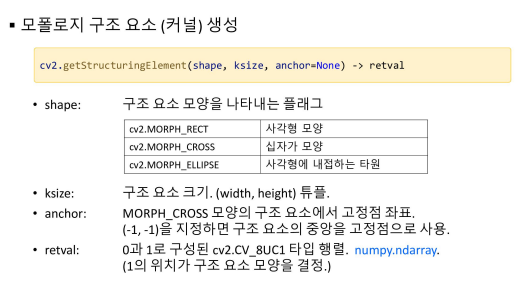

### 모폴로지 침심 연산

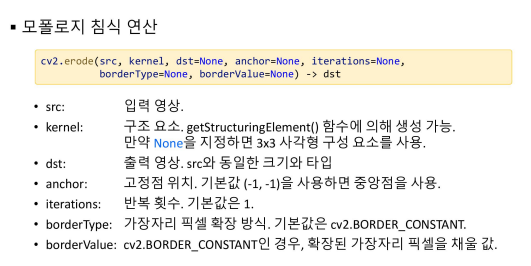


### 모폴로지 팽창 연산

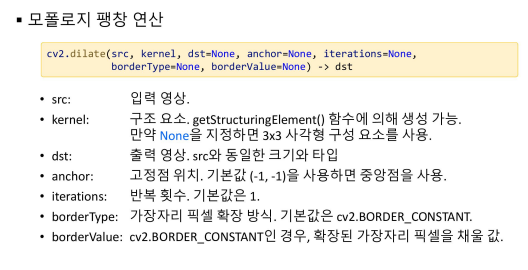



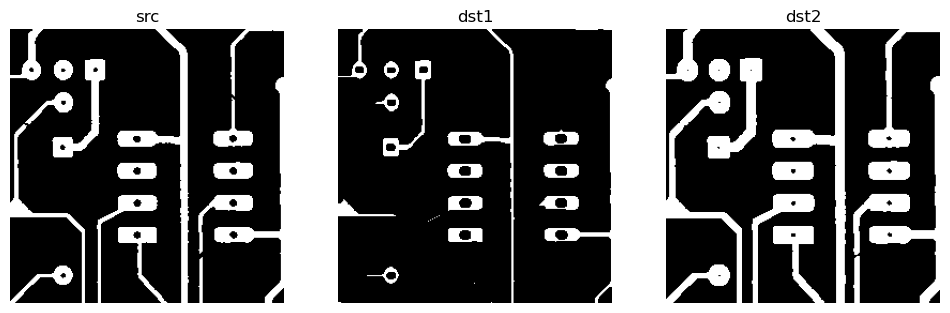

In [63]:
# 이진 영상의 침식과 팽창 예제

src = cv2.imread('images/circuit.bmp', cv2.IMREAD_GRAYSCALE)

se = cv2.getStructuringElement(cv2.MORPH_RECT, (5,3))

dst1 = cv2.erode(src, se)
dst2 = cv2.dilate(src, None)

plt.figure(figsize=(12,4))
plt.subplot(131), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(132), plt.title('dst1'), plt.axis('off'), plt.imshow(dst1, 'gray')
plt.subplot(133), plt.title('dst2'), plt.axis('off'), plt.imshow(dst2, 'gray')
plt.show() 

### 모폴로지 (2) : 열기와 닫기

#### 이진 영상의 열기(opening) 연산
- 열기 = 침식 -> 팽창

#### 이진 영상의 닫기(closing) 연산
- 닫기 = 팽창 -> 침식

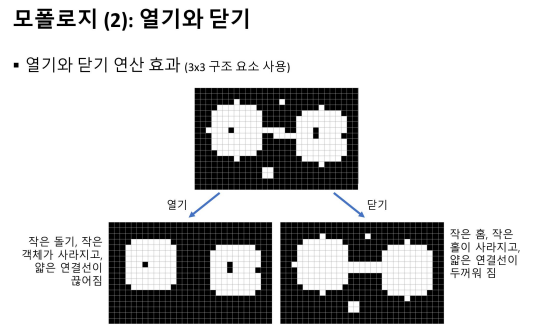

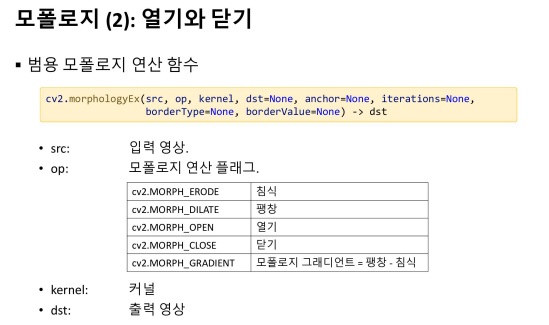

cnt1 : 1
cnt2 : 1


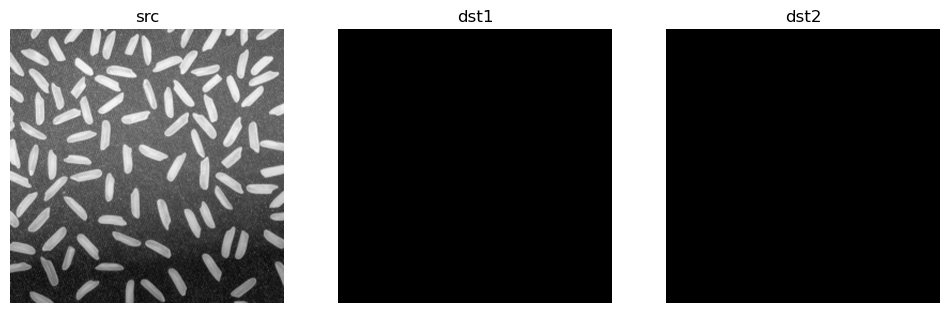

In [79]:
# 열기 연산을 이용한 잡음 제거 예제

src = cv2.imread('images/rice.png', cv2.IMREAD_GRAYSCALE)

# 지역
dst1 = np.zeros(src.shape, np.uint8) # zeros면 다 0이니까 안보이는게 정상아닌가..?
# _, dst1 = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


# src 영상에 지역 이진화 수행
cnt1, _ = cv2.connectedComponents(dst1) # 이진 영상에서 객체 개수 세기(잡음 포함)
print('cnt1 :', cnt1)
 
dst2 = cv2.morphologyEx(dst1, cv2.MORPH_OPEN, None) # 열기 연산(침식 후 팽창) : 작은 잡음 제거
# dst2 = cv2.erode(dst1, None)
# dst2 = cv2.dilate(dst1, None)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
# dst2 = cv2.morphologyEx(dst1, cv2.MORPH_OPEN, kernel)

cnt2, _ = cv2.connectedComponents(dst2) # 잡음 제거 후 객체 개수 다시 세기
print('cnt2 :', cnt2)

plt.figure(figsize=(12,4))
plt.subplot(131), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(132), plt.title('dst1'), plt.axis('off'), plt.imshow(dst1, 'gray')
plt.subplot(133), plt.title('dst2'), plt.axis('off'), plt.imshow(dst2, 'gray')
plt.show() 

### 레이블링
- 동일 객체에 속한 모든 픽셀에 고유한 번호를 매기는 작업
- 일반적으로 이진 영상에서 수행
- OpenCV에는 3.x 버전부터 최신 논문 기반의 레이블링 알고리즘 함수를 제공
- Connected component labeling

#### 픽셀의 연결 관계
- 4-이웃 연결 관계
- 8-이웃 연결 관계

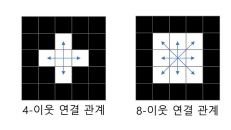

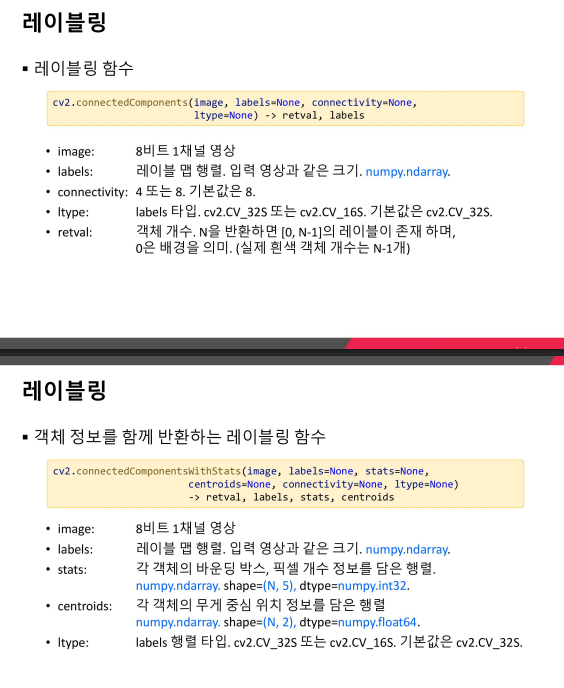

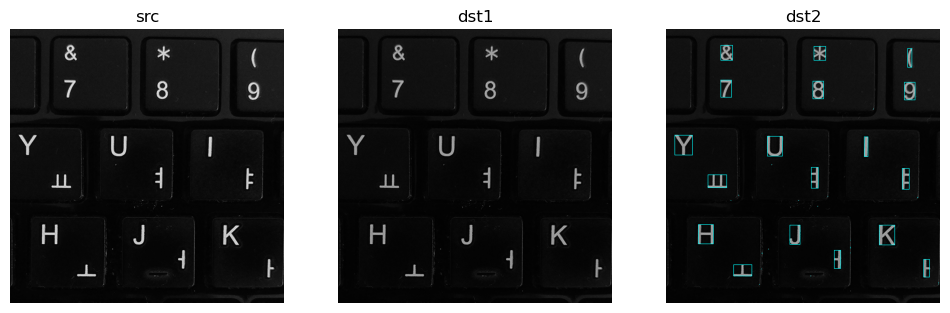

In [ ]:
# 키보드 영상에서 문자 영역 분할 예제

src = cv2.imread('images/keyboard.bmp', cv2.IMREAD_GRAYSCALE)

_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU)
cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)
# stats : 각 연결 요소에 대해 (x, y, w, h, area) 정보가 담겨 있음

dst1 = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for i in range(1, cnt) : # 배경은 제외하고 각 레이블 처리
    (x, y, w, h, area) = stats[i]
    
    # 너무 작은 것(노이즈 같은 것)은 무시하고 넘기려고 쓴 조건절 
    # 근데 조건절을 지워도 레이블이 잘 나오는 것 처럼 보이는 이유는 :
    # 이미지가 고해상도 이거나, 노이즈가 거의 없거나일 수 있음.
    # if area < 20 :
    #     continue
    
    dst2 = cv2.rectangle(dst, (x, y, w, h), (0, 255, 255))
    # plt.subplot2grid(1, 5, i), plt.title('dst'), plt.axis('off'), plt.imshow(dst, 'gray')
    
       
plt.figure(figsize=(12,4))
plt.subplot(131), plt.title('src'), plt.axis('off'), plt.imshow(src, 'gray')
plt.subplot(132), plt.title('dst1'), plt.axis('off'), plt.imshow(dst1, 'gray')
plt.subplot(133), plt.title('dst2'), plt.axis('off'), plt.imshow(dst2, 'gray')
plt.show() 

### 외곽선 검출
- 객체의 외곽선 좌표를 모두 추출하는 작업. Boundary tracking, Contour tracing
- 바깥쪽 & 안쪽 외곽선 -> 외곽선의 계층 구조도 표현 가능

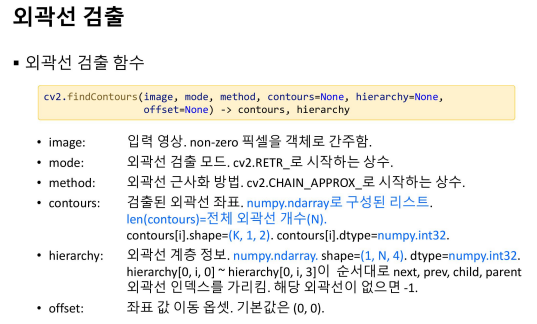

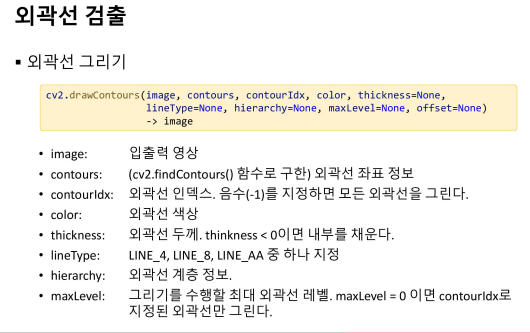

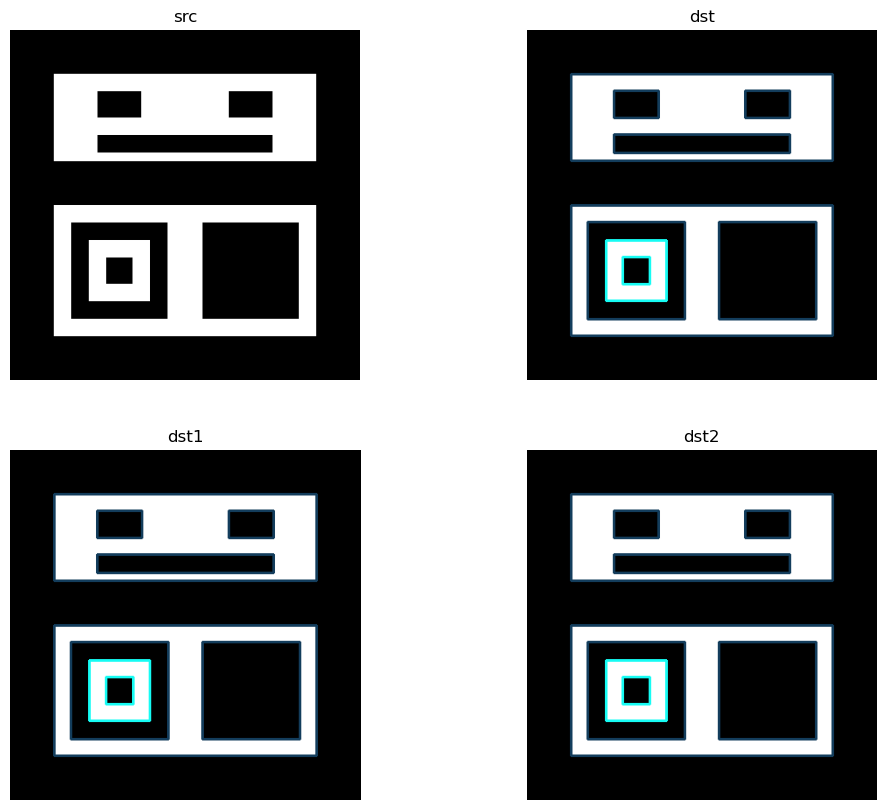

In [199]:
# 계층 정보를 사용하는 외곽선 검출 예제
import random

src = cv2.imread('images/contours.bmp', cv2.IMREAD_GRAYSCALE)

contours1, hier1 = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # 전체 계층 구조 추적 : 모든 외곽선을 찾고 부모, 자식, 형제 관계까지 전부 저장
contours2, hier2 = cv2.findContours(src, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # 2단계 계층 구조 : 모든 외곽선을 두 레벨로 나눔.
# 1단계 : 최상위 외곽선, 2단계 : 그 내부 외곽선(구멍), 이보다 더 복잡한 관계는 무시함

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
# plt.figure(figsize=(20,10))
# plt.subplot(222), plt.title('dst'), plt.axis('off'), plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

idx = 0
idx2 = 0
while idx >= 0 :
    c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    dst1 = cv2.drawContours(dst, contours1, idx, c, 2, cv2.LINE_8, hier1)
    dst2 = cv2.drawContours(dst, contours2, idx2, c, 2, cv2.LINE_8, hier2)
    idx = hier1[0, idx, 0]
    idx2 = hier2[0, idx2, 0]
    
    
plt.figure(figsize=(20,10))
plt.subplot(221), plt.title('src'), plt.axis('off'), plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.subplot(222), plt.title('dst'), plt.axis('off'), plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.subplot(223), plt.title('dst1'), plt.axis('off'), plt.imshow(cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB))
plt.subplot(224), plt.title('dst2'), plt.axis('off'), plt.imshow(cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB))
plt.subplots_adjust(wspace=-0.5)
plt.show() 

# drawContours()에서 next만 따라가서 순차 그리기만 했기 때문에 출력이 같아보임.
# 자식까지 그리도록 코드를 바꾸면 차이가 보일지도..?

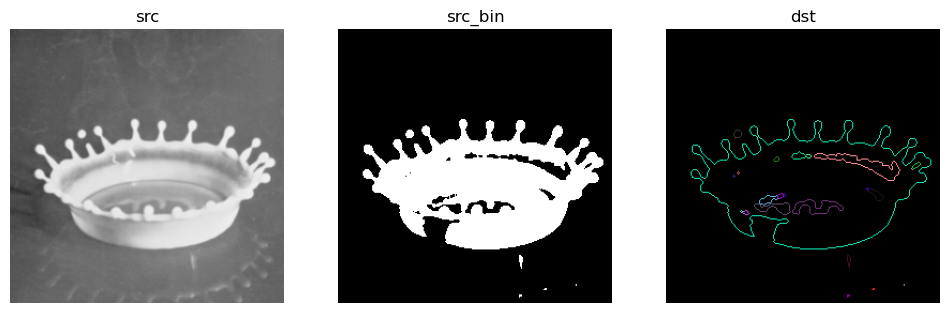

In [216]:
# 계층 정보를 사용하지 않는 외곽선 검출 예제

src = cv2.imread('images/milkdrop.bmp', cv2.IMREAD_GRAYSCALE)

_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU)
contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for i in range(len(contours)):
    c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(dst, contours, i, c, 1)
    

plt.figure(figsize=(12,4))
plt.subplot(131), plt.title('src'), plt.axis('off'), plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.subplot(132), plt.title('src_bin'), plt.axis('off'), plt.imshow(cv2.cvtColor(src_bin, cv2.COLOR_BGR2RGB))
plt.subplot(133), plt.title('dst'), plt.axis('off'), plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show() 

### 다양한 외곽선 함수

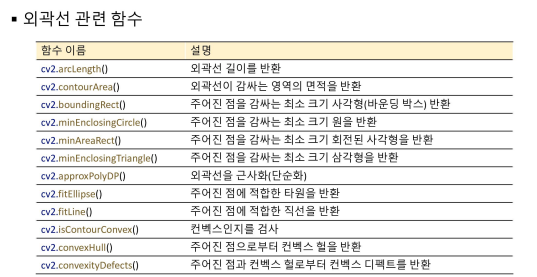

### 외곽선 길이 구하기 
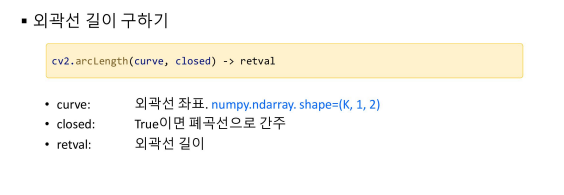

### 면적 구하기
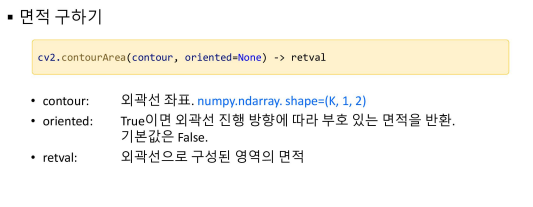

### 바운딩 박스(외곽선을 외접하여 둘러싸는 가장 작은 사각형) 구하기
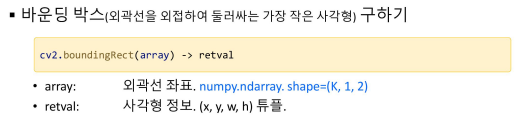

### 바운딩 서클(외곽선을 외접하여 둘러싸는 가장 작은 원) 구하기
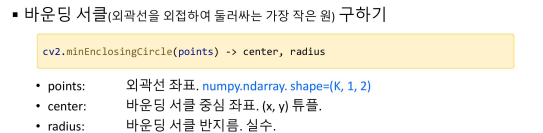

### 외곽선 근사화
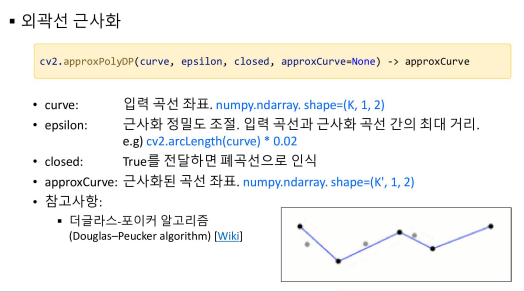

### Convex 검사
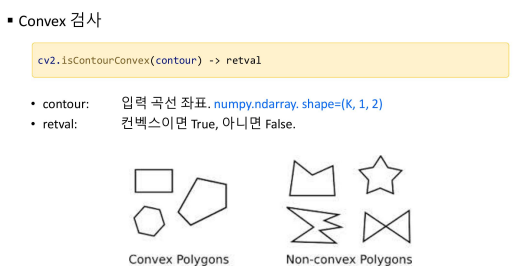

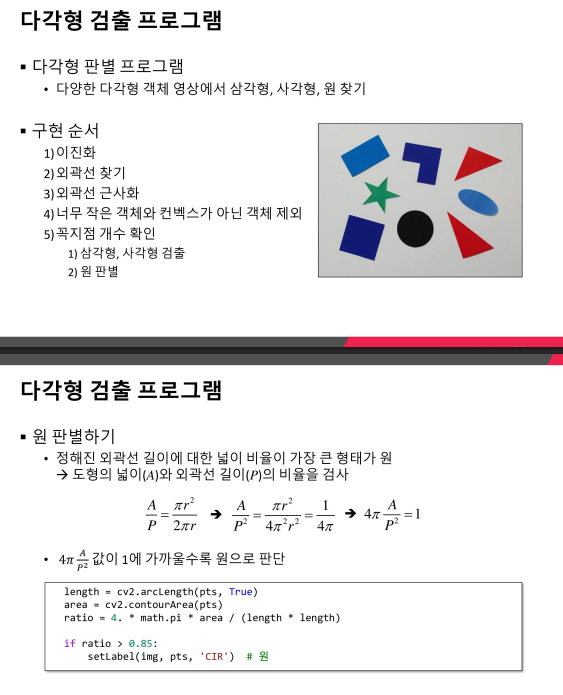

In [220]:
# 다각형 판별 프로그램 예제

img = cv2.imread('images/polygon.bmp', cv2.IMREAD_COLOR)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

def setLabel(img, pts, label):
    (x, y, w, h) = cv2.boundingRect(pts)
    pt1 = (x, y)
    pt2 = (x + w, y + h)
    cv2.rectangle(img, pt1, pt2, (0, 0, 255), 1)
    cv2.putText(img, label, pt1, cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))



for pts in contours :
    if cv2.contourArea(pts) < 400 : # 너무 작으면 무시
        continue
    
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True) * 0.02, True)
    vtc = len(approx)
    
    if vtc == 3 :
        setLabel(img, pts, 'TRI') # 삼각형
    elif vtc == 4 :
        setLabel(img, pts, 'RECT') # 사각형
    else:
        setLabel(img, pts, 'CIRCLE') # 원
        
    cv2.imshow('img', img)
    cv2.waitKey()
    cv2.destroyAllWindows()

### [실전 코딩] 명함 인식 프로그램
- 영상에서 명함을 검출하고, 명함 안의 텍스트를 인식하는 프로그램
- 가정 : 명함은 흰색이고, 충분히 크게 촬영되었고, 각진 사각형 모양이다.

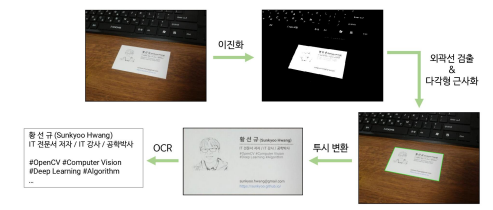

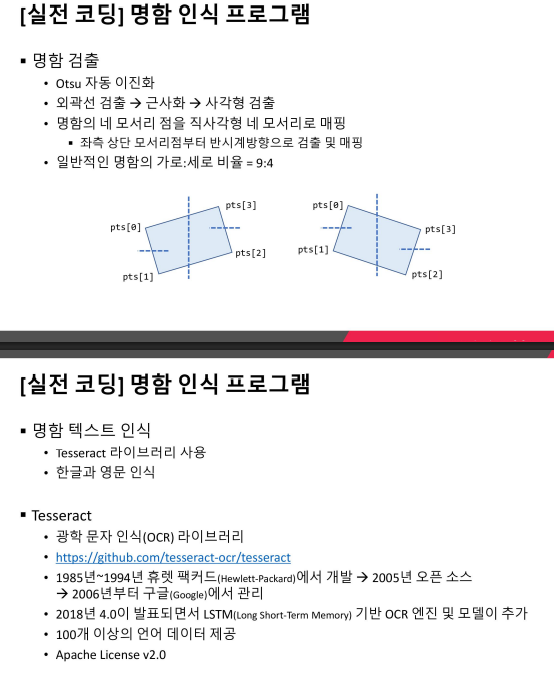

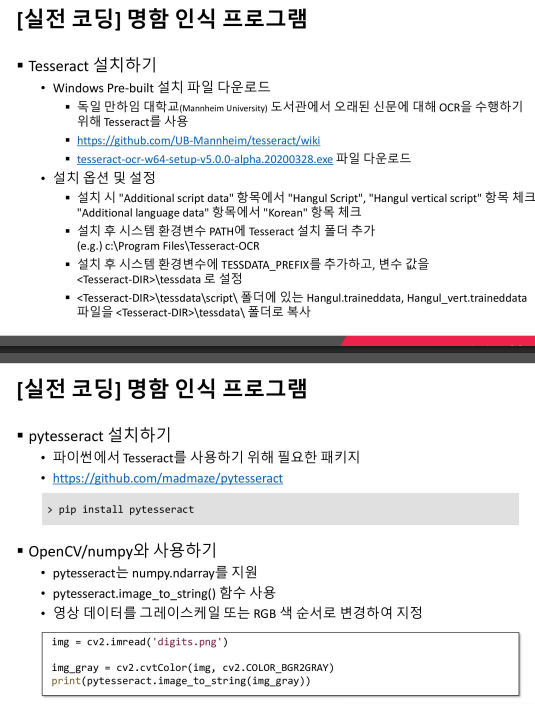

In [ ]:
# Tesseract-ocr 설치하기

# 1. tesseract-ocr-w64-setup-v5.0.0-alpha.20200328 파일 다운로드 
#    (https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-w64-setup-v5.0.0-alpha.20200328.exe)
# 2. 설치 시 "Additional script data" 항목에서 "Hangul Script", "Hangul vertical script" 항목 체크,
#    "Additional language data" 항목에서 "Korean" 항목 체크.
# 4. 설치 후 시스템 환경변수 PATH에 Tesseract 설치 폴더 추가
#    (e.g.) c:\Program Files\Tesseract-OCR
# 4. 설치 후 시스템 환경변수에 TESSDATA_PREFIX를 추가하고, 변수 값을 <Tesseract-DIR>\tessdata 로 설정
# 5. <Tesseract-DIR>\tessdata\script\ 폴더에 있는 Hangul.traineddata, Hangul_vert.traineddata 파일을
#    <Tesseract-DIR>\tessdata\ 폴더로 복사
# 6. 명령 프롬프트 창에서 pip install pytesseract 명령 입력

import sys
import random
import numpy as np
import cv2
import pytesseract


def reorderPts(pts):
    idx = np.lexsort((pts[:, 1], pts[:, 0]))  # 칼럼0 -> 칼럼1 순으로 정렬한 인덱스를 반환
    pts = pts[idx]  # x좌표로 정렬

    if pts[0, 1] > pts[1, 1]:
        pts[[0, 1]] = pts[[1, 0]]

    if pts[2, 1] < pts[3, 1]:
        pts[[2, 3]] = pts[[3, 2]]

    return pts


# 영상 불러오기
filename = 'images/namecard1.jpg'
if len(sys.argv) > 1:
    filename = sys.argv[1]

src = cv2.imread(filename)

if src is None:
    print('Image load failed!')
    sys.exit()

# 출력 영상 설정
dw, dh = 720, 400
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)
dst = np.zeros((dh, dw), np.uint8)

# 입력 영상 전처리
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
_, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 외곽선 검출 및 명함 검출
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cpy = src.copy()
for pts in contours:
    # 너무 작은 객체는 무시
    if cv2.contourArea(pts) < 1000:
        continue

    # 외곽선 근사화
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    # 컨벡스가 아니고, 사각형이 아니면 무시
    if not cv2.isContourConvex(approx) or len(approx) != 4:
        continue

    cv2.polylines(cpy, [approx], True, (0, 255, 0), 2, cv2.LINE_AA)
    srcQuad = reorderPts(approx.reshape(4, 2).astype(np.float32))

pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(src, pers, (dw, dh))

dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
print(pytesseract.image_to_string(dst_gray, lang='Hangul+eng'))

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


황 선 규 (Sunkyoo Hwang)

17 전문서 저자 / 17 강사 / 공 학 박사

#OpenCV #Computer Vision
#Deep Learning #Algorithm

sunkyoo.hwang@gmail.com
https://sunkyoo.github.io/



### 그랩컷(GrabCut)
- 그래프 컷(graph cut) 기반 영역 분할 알고리즘
- 영상의 픽셀을 그래프 정점으로 간주하고, 픽셀들을 두 개의 그룹으로 나누는 최적의 컷을 찾는 방식

### 그랩컷 영상 분할 동작 방식
- 사각형 지정 자동 분할
- 사용자가 지정한 전경/배경 정보를 활용하여 영상 분할


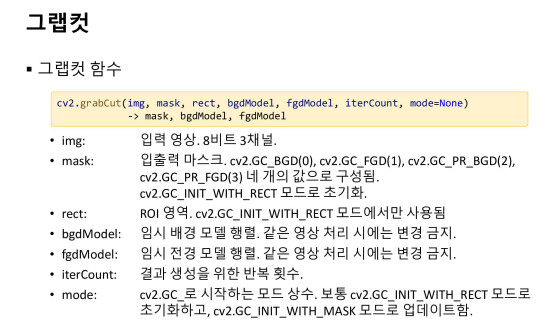

In [ ]:
# 그랩컷 영상 분할 예제

src = cv2.imread('images/nemo.jpg')

# cv2.selectROI() : 사각형을 마우스로 직접 드래그 지정, 드래그 이벤트 자동 지원 + enter 확정, esc 취소
rc = cv2.selectROI(src)

mask = np.zeros(src.shape[:2], np.uint8)

# cv2.GC_INIT_WITH_RECT : 사각형 영역만 주면 내부적으로 알아서 배경/전경 추정
cv2.grabCut(src, mask, rc, None, None, 5, cv2.GC_INIT_WITH_RECT)

# 0: cv2.GC_BGD, 2: cv2.GC_PRBGD
mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')
# mask 행렬에서 값이 0 또는 2인 원소는 0으로, 그렇지 않은 원소는 1로 설정
# 0: 확실한배경(cv2.GC_BGD), 2: 아마 배경일 확률 높은 픽셀(cv2.GC_PR_BGD) -> 전부 0으로 설정해서 제거, 나머지(전경)는 1로 설정

dst = src * mask2[:, :, np.newaxis]

# 초기 분할 결과 출력
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


In [3]:
# 그랩컷 영상 분할 예제 2

import sys
import numpy as np
import cv2

# 입력 영상 불러오기
src = cv2.imread('images/messi5.jpg')

if src is None:
    print('Image load failed!')
    sys.exit()

# 사각형 지정을 통한 초기 분할
mask = np.zeros(src.shape[:2], np.uint8)  # 마스크
bgdModel = np.zeros((1, 65), np.float64)  # 배경 모델
fgdModel = np.zeros((1, 65), np.float64)  # 전경 모델

rc = cv2.selectROI(src)

cv2.grabCut(src, mask, rc, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_RECT)

# 0: cv2.GC_BGD, 2: cv2.GC_PR_BGD
mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')
dst = src * mask2[:, :, np.newaxis]

# 초기 분할 결과 출력
cv2.imshow('dst', dst)

# 마우스 이벤트 처리 함수 등록
def on_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(dst, (x, y), 3, (255, 0, 0), -1)
        cv2.circle(mask, (x, y), 3, cv2.GC_FGD, -1)
        cv2.imshow('dst', dst)
    elif event == cv2.EVENT_RBUTTONDOWN:
        cv2.circle(dst, (x, y), 3, (0, 0, 255), -1)
        cv2.circle(mask, (x, y), 3, cv2.GC_BGD, -1)
        cv2.imshow('dst', dst)
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.circle(dst, (x, y), 3, (255, 0, 0), -1)
            cv2.circle(mask, (x, y), 3, cv2.GC_FGD, -1)
            cv2.imshow('dst', dst)
        elif flags & cv2.EVENT_FLAG_RBUTTON:
            cv2.circle(dst, (x, y), 3, (0, 0, 255), -1)
            cv2.circle(mask, (x, y), 3, cv2.GC_BGD, -1)
            cv2.imshow('dst', dst)


cv2.setMouseCallback('dst', on_mouse)

while True:
    key = cv2.waitKey()
    if key == 13:  # ENTER
        # 사용자가 지정한 전경/배경 정보를 활용하여 영상 분할
        cv2.grabCut(src, mask, rc, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_MASK)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        dst = src * mask2[:, :, np.newaxis]
        cv2.imshow('dst', dst)
    elif key == 27:
        break

cv2.destroyAllWindows()


### 모멘트 기반 객체 검출
- 영상의 형태를 표현하는 일련의 상수값
- 특정 함수 집합과의 상관 관계 형태로 계산

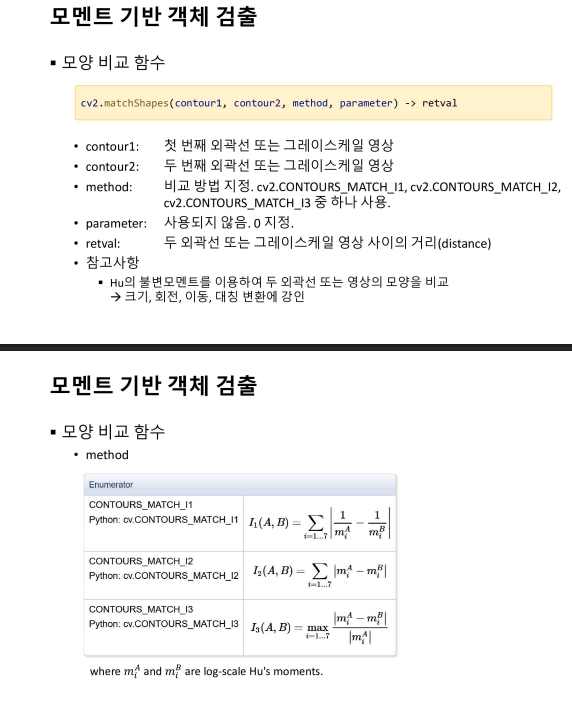

In [9]:
# 모멘트 기반 객체 검출 예제

# 영상 불러오기
obj = cv2.imread('images/spades.png', cv2.IMREAD_GRAYSCALE)
src = cv2.imread('images/symbols.png', cv2.IMREAD_GRAYSCALE)

if src is None or obj is None:
    print('Image load failed!')
    sys.exit()

# 객체 영상 외곽선 검출
_, obj_bin = cv2.threshold(obj, 128, 255, cv2.THRESH_BINARY_INV)
obj_contours, _ = cv2.findContours(obj_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
obj_pts = obj_contours[0]

# 입력 영상 분석
_, src_bin = cv2.threshold(src, 128, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 결과 영상
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

# 입력 영상의 모든 객체 영역에 대해서
for pts in contours:
    if cv2.contourArea(pts) < 1000:
        continue

    rc = cv2.boundingRect(pts)
    cv2.rectangle(dst, rc, (255, 0, 0), 1)

    # 모양 비교
    dist = cv2.matchShapes(obj_pts, pts, cv2.CONTOURS_MATCH_I3, 0)

    cv2.putText(dst, str(round(dist, 4)), (rc[0], rc[1] - 3),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1, cv2.LINE_AA)

    if dist < 0.1:
        cv2.rectangle(dst, rc, (0, 0, 255), 2)

cv2.imshow('obj', obj)
cv2.imshow('dst', dst)
cv2.waitKey(0)
cv2.destroyAllWindows()


### 템플릿 매칭(1) : 이해하기
- 입력 영상에서 (작은 크기의) 템플릿 영상과 일치하는 부분을 찾는 기법
- 템플릿 : 찾을 대상이 되는 작은 영상. 패치(patch)

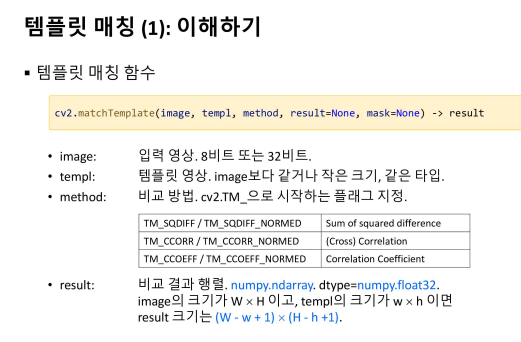

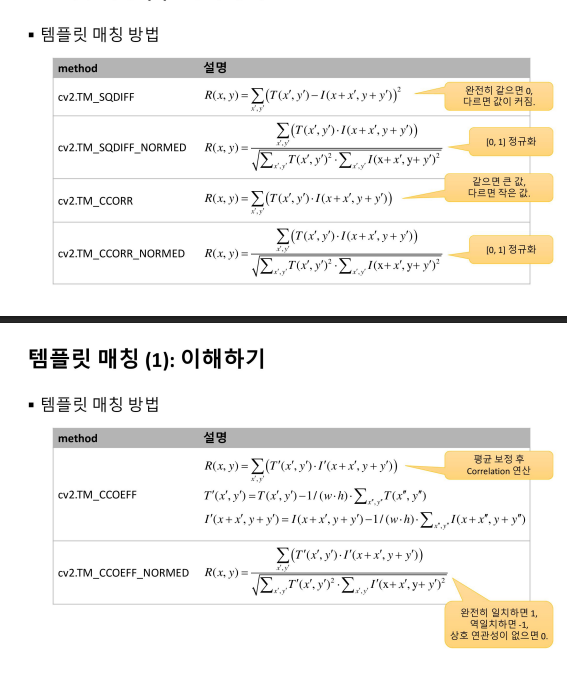

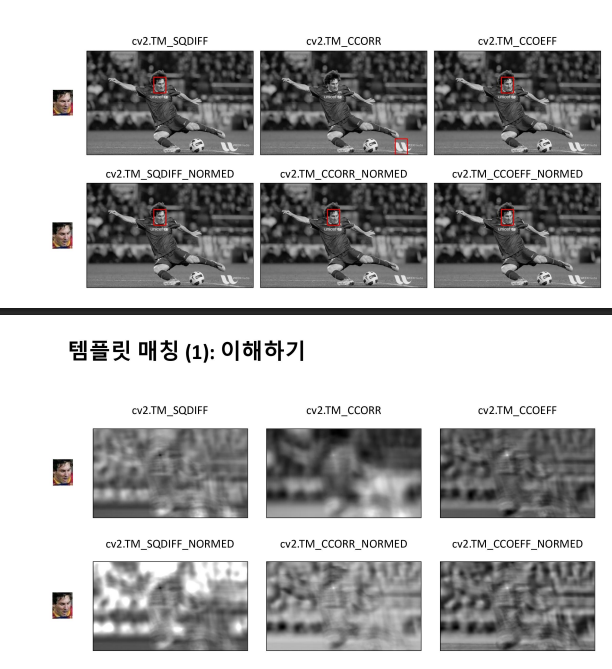

maxv: 0.2874561548233032
maxloc: (9, 116)


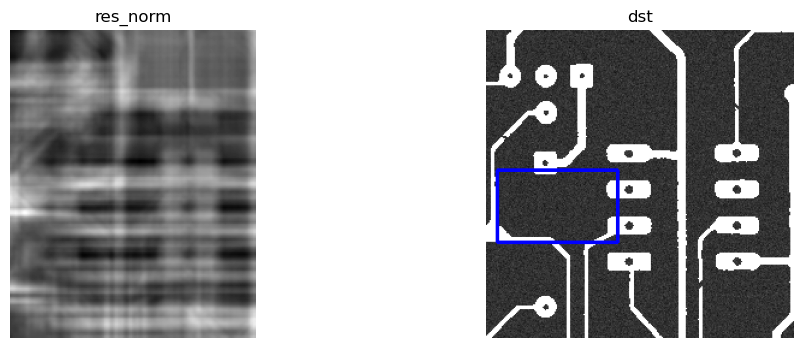

In [17]:
# 템플릿 매칭 예제
import matplotlib.pyplot as plt

# 입력 영상 & 템플릿 영상 불러오기
src = cv2.imread('images/circuit.bmp', cv2.IMREAD_GRAYSCALE)
templ = cv2.imread('images/crystal.bmp', cv2.IMREAD_GRAYSCALE)

if src is None or templ is None:
    print('Image load failed!')
    sys.exit()

# 입력 영상 밝기 50증가, 가우시안 잡음(sigma=10) 추가
noise = np.zeros(src.shape, np.int32)
cv2.randn(noise, 50, 10)
src = cv2.add(src, noise, dtype=cv2.CV_8UC3)

# 템플릿 매칭 & 결과 분석
res = cv2.matchTemplate(src, templ, cv2.TM_CCOEFF_NORMED)
res_norm = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

_, maxv, _, maxloc = cv2.minMaxLoc(res)
print('maxv:', maxv)
print('maxloc:', maxloc)

# 매칭 결과를 빨간색 사각형으로 표시
th, tw = templ.shape[:2]
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
cv2.rectangle(dst, maxloc, (maxloc[0] + tw, maxloc[1] + th), (0, 0, 255), 2)

# # 결과 영상 화면 출력
# cv2.imshow('res_norm', res_norm)
# cv2.imshow('dst', dst)
# cv2.waitKey()
# cv2.destroyAllWindows()
plt.figure(figsize=(12,4))
plt.subplot(121), plt.title('res_norm'), plt.axis('off'), plt.imshow(res_norm, 'gray')
plt.subplot(122), plt.title('dst'), plt.axis('off'), plt.imshow(dst, 'gray')
plt.show() 

### 템플릿 매칭(2) : 인쇄체 숫자 인식
- 여러 개의 클래스 중에서 가장 유사한 클래스를 선택

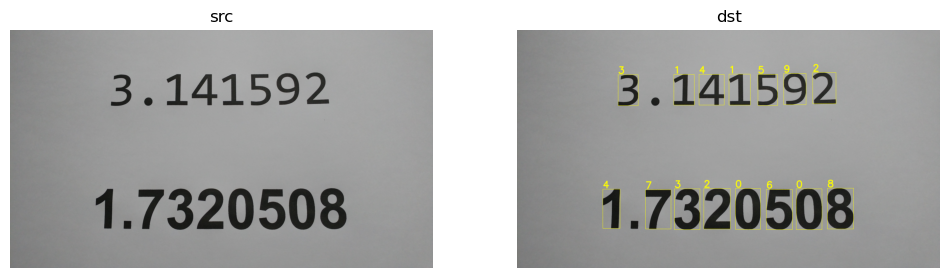

In [22]:
# 인쇄체 숫자 인식 예제

import sys
import numpy as np
import cv2


def load_digits():
    img_digits = []

    for i in range(10):
        filename = './digits/digit{}.bmp'.format(i)
        img_digits.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))

        if img_digits[i] is None:
            return None

    return img_digits


def find_digit(img, img_digits):
    max_idx = -1
    max_ccoeff = -1

    # 최대 NCC 찾기
    for i in range(10):
        img = cv2.resize(img, (100, 150))
        res = cv2.matchTemplate(img, img_digits[i], cv2.TM_CCOEFF_NORMED)

        if res[0, 0] > max_ccoeff:
            max_idx = i
            max_ccoeff = res[0, 0]

    return max_idx



# 입력 영상 불러오기
src = cv2.imread('images/digits_print.bmp')

if src is None:
    print('Image load failed!')
    

# 100x150 숫자 영상 불러오기
img_digits = load_digits()  # list of ndarray

if img_digits is None:
    print('Digit image load failed!')
    

# 입력 영상 이진화 & 레이블링
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
_, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
cnt, _, stats, _ = cv2.connectedComponentsWithStats(src_bin)

# 숫자 인식 결과 영상 생성
dst = src.copy()
for i in range(1, cnt):
    (x, y, w, h, s) = stats[i]

    if s < 1000:
        continue

    # 가장 유사한 숫자 이미지를 선택
    digit = find_digit(src_gray[y:y+h, x:x+w], img_digits)
    cv2.rectangle(dst, (x, y, w, h), (0, 255, 255))
    cv2.putText(dst, str(digit), (x, y - 4), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 255), 2, cv2.LINE_AA)

# cv2.imshow('dst', dst)
# cv2.waitKey()
# cv2.destroyAllWindows()

plt.figure(figsize=(12,4))
plt.subplot(121), plt.title('src'), plt.axis('off'), plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.title('dst'), plt.axis('off'), plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show() 


### 케스케이드 분류기 : 얼굴 검출

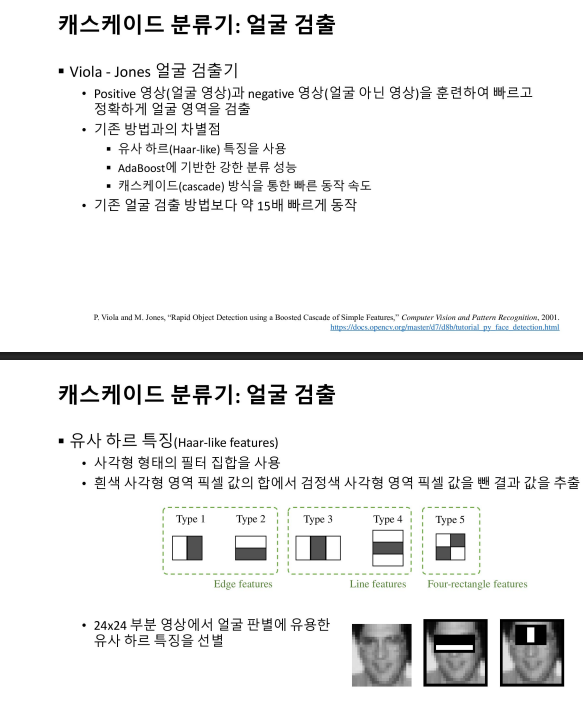

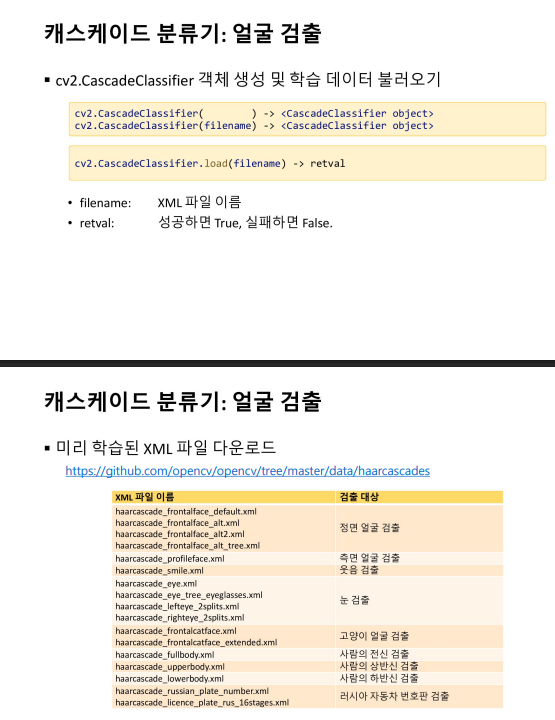

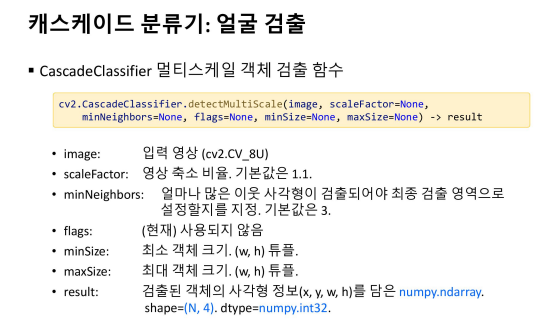

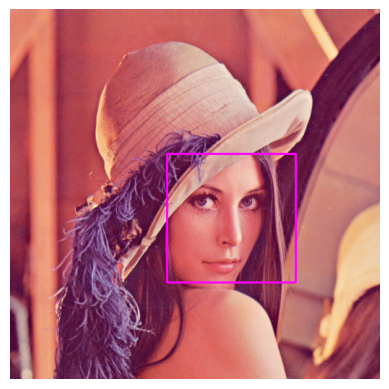

In [ ]:
# 정면 얼굴 검출 예제

src = cv2.imread('images/lenna.bmp')

classifier = cv2.CascadeClassifier()
classifier.load('haarcascade_frontalface_alt2.xml')

faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    face_img = src[y:y+h, x:x+w]
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)
    
plt.axis('off'), plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))

# cv2.imshow('src', src)
# cv2.waitKey()
# cv2.destroyAllWindows()



((0.0, 1.0, 0.0, 1.0), <matplotlib.image.AxesImage at 0x1e2d63b9220>)

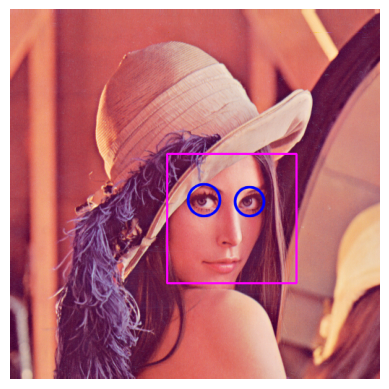

In [34]:
# 눈까지

import sys
import numpy as np
import cv2


src = cv2.imread('images/lenna.bmp')

if src is None:
    print('Image load failed!')
    sys.exit()

face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')

if face_classifier.empty() or eye_classifier.empty():
    print('XML load failed!')
    sys.exit()

faces = face_classifier.detectMultiScale(src)

for (x1, y1, w1, h1) in faces:
    cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)

    faceROI = src[y1:y1 + h1 // 2, x1:x1 + w1]
    eyes = eye_classifier.detectMultiScale(faceROI)

    for (x2, y2, w2, h2) in eyes:
        center = (x2 + w2 // 2, y2 + h2 // 2)
        cv2.circle(faceROI, center, w2 // 2, (255, 0, 0), 2, cv2.LINE_AA)
        
plt.axis('off'), plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))


# cv2.imshow('src', src)
# cv2.waitKey()
# cv2.destroyAllWindows()


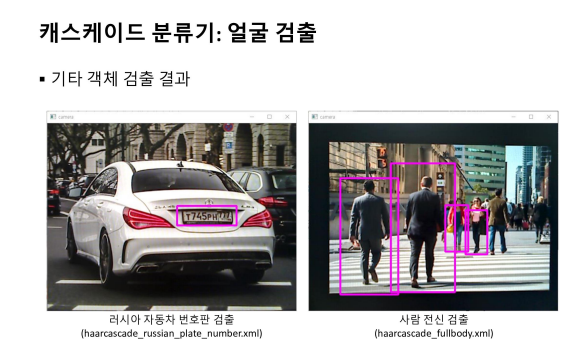

### HOG 보행자 검출
- 영상의 지역적 그래디언트 방향 정보를 특정 벡터로 사용

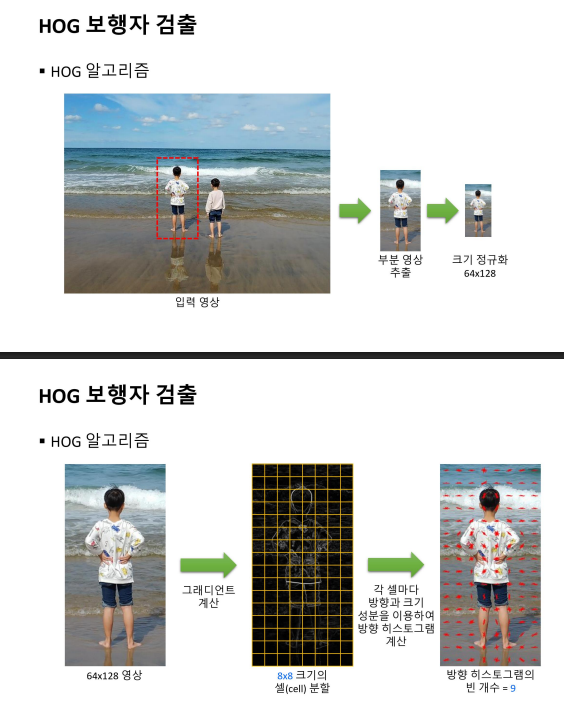

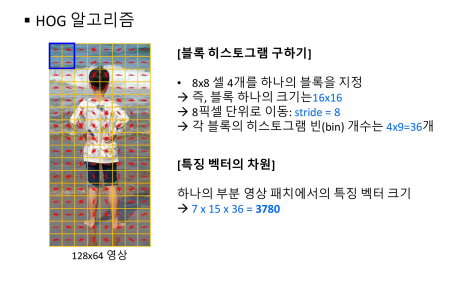

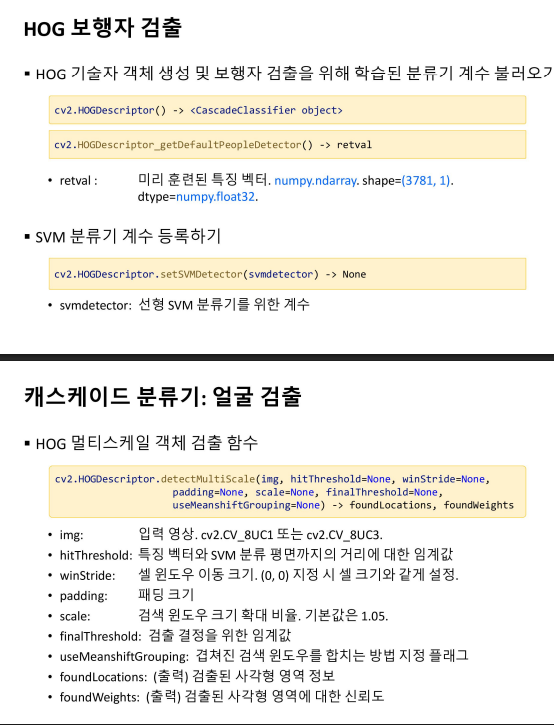

In [ ]:
# HOG 보행자 검출 예제
import random

cap = cv2.VideoCapture('videos/vtest.avi')

# 보행자 검출을 위한 HOG 기술자 설정
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

while True :
    ret, frame = cap.read()
    
        # 매 프레임마다 보행자 검출
    detected, _ = hog.detectMultiScale(frame)
    
    for (x, y, w, h) in detected:
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(frame, (x, y), (x + w, y + h), c, 3)
        
        cv2.imshow('frame', frame)
    if cv2.waitKey(10) == 27:
        break

cv2.destroyAllWindows()
